In [54]:
import numpy as np
import pandas as pd
import os
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import unicodedata
import contractions
import shap
import re
import spacy
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mj_ch\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Sentiment : 1 - Negetive, 3 - Neutral, 5 - Positive

In [55]:
data = pd.read_csv('Apple-Twitter-Sentiment-DFE.csv')
data = data[data['sentiment'] != 'not_relevant']

In [56]:
sentiment_dict = {'1' : "negative", '3' : "neutral", '5' : "positive"}
data['sentiment'] = data['sentiment'].apply(lambda x : sentiment_dict[x])

In [57]:
data2 = pd.read_csv('tweets/tweets_labelled_09042020_16072020.csv', delimiter=';')
data2 = data2[data2.sentiment.isna() == False]

## Combine both the data sets

In [58]:
cols = ['text', 'sentiment']
df2 = pd.concat([data[cols], data2[cols]], axis = 0)
df2 = df2.reset_index()
df2 = df2[['text', 'sentiment']]

In [59]:
df2.head()

,text,sentiment
0,#AAPL:The 10 best Steve Jobs emails ever...htt...,neutral
1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,neutral
2,My cat only chews @apple cords. Such an #Apple...,neutral
3,I agree with @jimcramer that the #IndividualIn...,neutral
4,Nobody expects the Spanish Inquisition #AAPL,neutral


In [60]:
df2.shape

(5104, 2)

## General Twitter Sentiment Analysis Data

In [61]:
df = pd.read_csv('twitter_training.csv')
df.columns = ['tweet_id', 'entity', 'sentiment', 'text']
df = df[df.sentiment != 'Irrelevant']

In [62]:
sentiment_dict = {'Negative' : "negative", 'Neutral' : "neutral", 'Positive' : "positive"}
df['sentiment'] = df['sentiment'].apply(lambda x : sentiment_dict[x])
df = df[cols]

In [63]:
df.shape, df2.shape

((61691, 2), (5104, 2))

# Text cleanup

In [16]:
def preprocess_text(text):
    # Remove accents
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Fix contractions
    text = contractions.fix(text)
    
    # Remove URLs
    def remove_URL(text):
        """Remove URLs from a text string"""
        return re.sub(r"\S*https?:\S*", "", text)
    
    text = remove_URL(text)
    
    # Remove special characters
    def remove_special_characters(text):
        # define the pattern to keep
        pat = r'[^a-zA-z.,!?/:;\"\'\s]' 
        return re.sub(pat, '', text)
    
    text = remove_special_characters(text)
    
    # Remove white spaces and convert to lowercase
    def remove_extra_whitespace_tabs_lower(text):
        pattern = r'^\s*|\s\s*'
        return re.sub(pattern, ' ', text).strip().lower()
    
    text = remove_extra_whitespace_tabs_lower(text)
    
    return text

In [64]:
# Clean the data individually, and split individually
# Convert labels to numeric encoded
sentiment_dict = {'negative' : 0, 'neutral' : 1, 'positive' : 2}

for t in (df, df2):
    t['sentiment'] = t['sentiment'].apply(lambda x : sentiment_dict[x])

In [65]:
X_trains = []
X_tests = []
Y_trains = []
Y_tests = []
for t in (df, df2):
    x1, x2, y1, y2 = train_test_split(t['text'], t['sentiment'], test_size = 0.2, random_state=123, stratify=t['sentiment'])
    X_trains.append(x1)
    X_tests.append(x2)
    Y_trains.append(y1)
    Y_tests.append(y2)

In [66]:
[t.shape for t in X_trains], [t.shape for t in X_tests]

([(49352,), (4083,)], [(12339,), (1021,)])

In [67]:
[t.shape for t in Y_trains], [t.shape for t in Y_tests]

([(49352,), (4083,)], [(12339,), (1021,)])

In [68]:
X_train = pd.concat(X_trains, axis=0)

In [69]:
Y_train = pd.concat(Y_trains, axis=0)

# Tokenization

In [37]:
def vectorize_raw_text(text, vectorizer = None):
    if(vectorizer == None):
        vectorizer = TfidfVectorizer(analyzer='word', ngram_range = (1,3), stop_words='english')
        vectorizer.fit(text)
    dtm = vectorizer.transform(text)
    # dtm_df = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())
    return dtm, vectorizer

In [38]:
dtm, vectorizer = vectorize_raw_text(df['text'])

In [39]:
dtm.shape

(61691, 458055)

# Model and Train

In [40]:
# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(dtm, df['sentiment'], test_size = 0.3, random_state=123, stratify=df['sentiment'])

In [41]:
X_train.shape

(43183, 458055)

In [42]:
model = XGBClassifier()
model.fit(X_train, Y_train)
model.score(X_test, Y_test)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:34:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7155824508320726

In [43]:
model.score(X_train, Y_train)

0.7682421323205891

In [164]:
Y_train.value_counts()

neutral     1810
negative    1097
positive     665
Name: sentiment, dtype: int64

In [165]:
Y_test.value_counts()

neutral     776
negative    470
positive    286
Name: sentiment, dtype: int64

# Let's try BERT

In [32]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

# Create and Train model

In [75]:
%load_ext autoreload
%autoreload 2

In [99]:
import SentimentModel

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [87]:
sentimentModel = SentimentModel.SentimentModel(model_path='model.save', n_samples=X_train.shape[0], epochs=40)

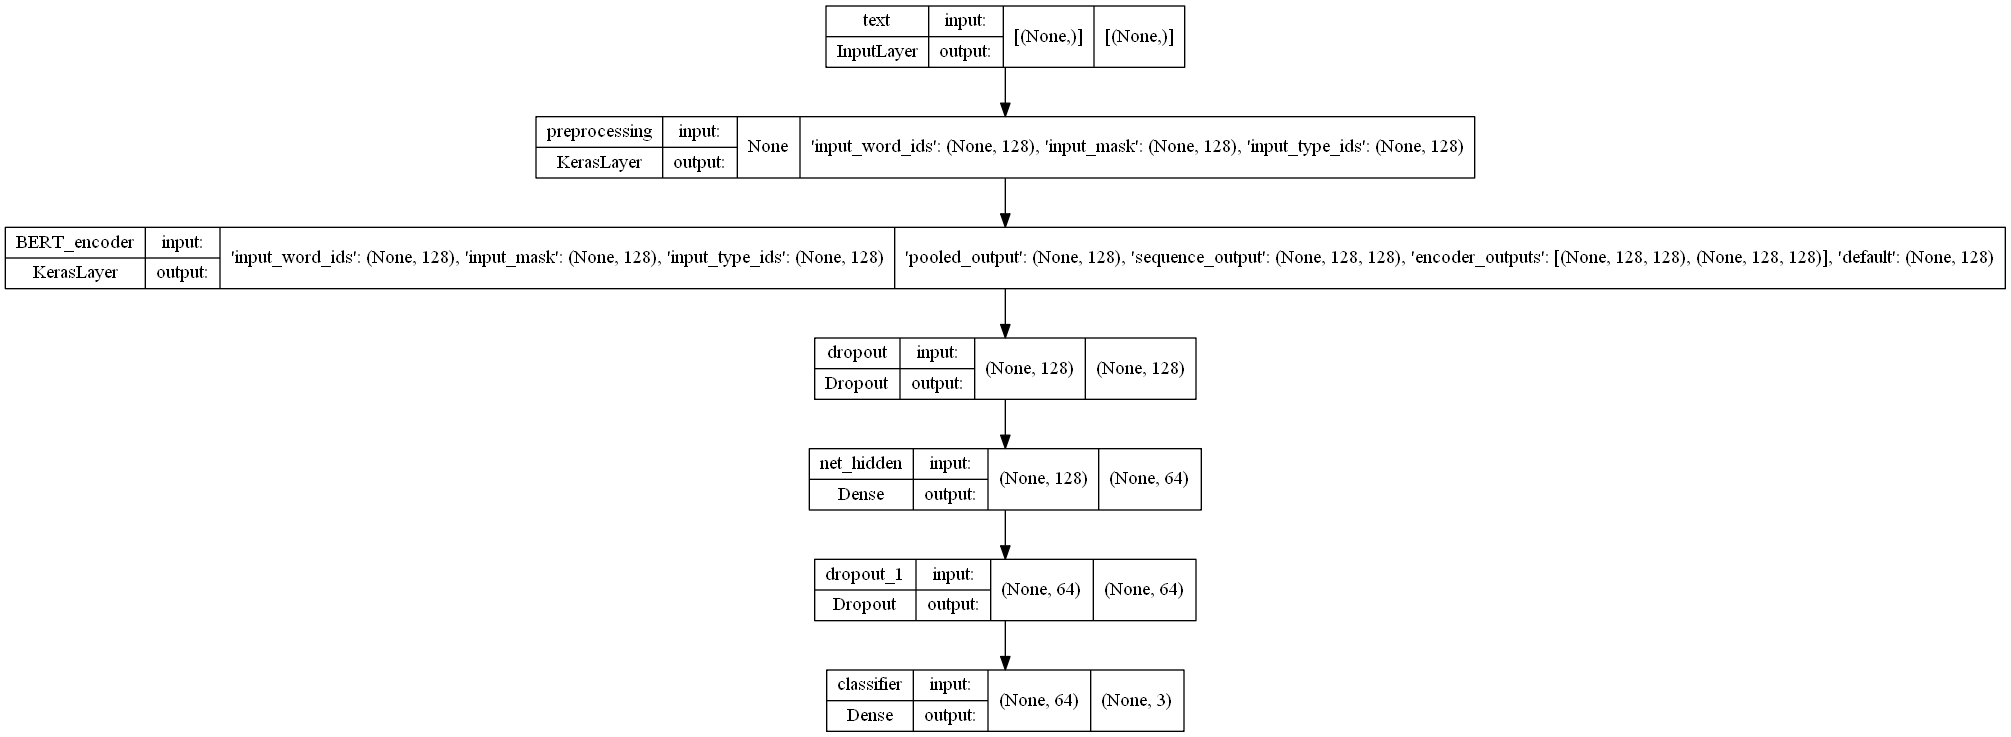

In [36]:
tf.keras.utils.plot_model(sentimentModel.model, show_shapes=True)

In [89]:
history = sentimentModel.fit(X_train, Y_train, epochs=40, validation_data=[X_tests[0], Y_tests[0]])

Epoch 1/40
1670/1670 [==============================] - 162s 95ms/step - loss: 1.9018 - sparse_categorical_accuracy: 0.3131 - val_loss: 1.6191 - val_sparse_categorical_accuracy: 0.2969
Epoch 2/40
1670/1670 [==============================] - 163s 98ms/step - loss: 1.4043 - sparse_categorical_accuracy: 0.3266 - val_loss: 1.0873 - val_sparse_categorical_accuracy: 0.3943
Epoch 3/40
1670/1670 [==============================] - 156s 94ms/step - loss: 1.1276 - sparse_categorical_accuracy: 0.3926 - val_loss: 1.0200 - val_sparse_categorical_accuracy: 0.5066
Epoch 4/40
1670/1670 [==============================] - 155s 93ms/step - loss: 1.0703 - sparse_categorical_accuracy: 0.4410 - val_loss: 0.9843 - val_sparse_categorical_accuracy: 0.5417
Epoch 5/40
1670/1670 [==============================] - 156s 94ms/step - loss: 1.0337 - sparse_categorical_accuracy: 0.4824 - val_loss: 0.9506 - val_sparse_categorical_accuracy: 0.5675
Epoch 6/40
1670/1670 [==============================] - 159s 95ms/step - lo

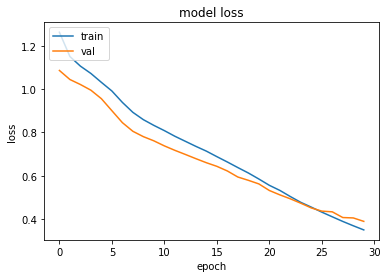

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [90]:
sentimentModel.evaluate(X_tests[1], Y_tests[1])

32/32 [==============================] - 2s 54ms/step - loss: 1.0815 - sparse_categorical_accuracy: 0.6787


[1.0814855098724365, 0.6787463426589966]

In [95]:
sentimentModel.save(path="models/model")